In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from sklearn.metrics import mean_absolute_error

from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor, AdaBoostRegressor, RandomForestRegressor
from sklearn.svm import SVR
from xgboost import XGBRegressor
from catboost import CatBoostRegressor

from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer
from sklearn.compose import make_column_selector as selector
from sklearn.compose import ColumnTransformer, TransformedTargetRegressor
from sklearn.preprocessing import OneHotEncoder, StandardScaler, OrdinalEncoder
from sklearn.pipeline import Pipeline
from sklearn.model_selection import KFold, RandomizedSearchCV, cross_val_predict, cross_validate, GridSearchCV, train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler, MaxAbsScaler, RobustScaler

import warnings
warnings.filterwarnings('ignore')

import shap
shap.initjs()


df_normal_quality = pd.read_csv('dataframes/df_normal_quality.csv', index_col= 0).reset_index(drop = True)
y = df_normal_quality.SalePrice
X = df_normal_quality.drop(['SalePrice', 'PID'], axis =1).copy()

kf = KFold(n_splits=5, shuffle=True, random_state=42)
numerical_columns_selector = selector(dtype_exclude=object)
categorical_columns_selector = selector(dtype_include=object)
numerical_columns = numerical_columns_selector(X)
categorical_columns = categorical_columns_selector(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 2)

# Lasso
## Tuned with Optuna 

In [30]:
categorical_preprocessor = OneHotEncoder(handle_unknown="ignore")               

numerical_preprocessor = RobustScaler()


preprocessor = ColumnTransformer(
    [
        ("robust_scaler", numerical_preprocessor, numerical_columns),
        ("one-hot-encoder", categorical_preprocessor, categorical_columns),
    ]
)

lasso_pipe = Pipeline(steps=[("Preprocess", preprocessor), 
                             ("Regressor", TransformedTargetRegressor(regressor = Lasso(alpha = 0.00030733929099045147),
                                                                func =np.log, inverse_func=np.exp))])

scores = cross_val_score(lasso_pipe, X, y, cv = kf, error_score='raise')

print('Lasso')
print('score', scores.mean())
print('standard deviation', scores.std())

lasso_pipe.fit(X,y)

lasso_predictions = lasso_pipe.predict(X)
print('predicted prices', lasso_predictions)

lasso_mae = mean_absolute_error(y, lasso_predictions)
print('Mean Absolute Error:', lasso_mae)

lasso_mpv = lasso_predictions.mean()
print ('Mean Predicted Home Value', lasso_mpv)

mhv = y.mean()
print ('Mean  Home Value', mhv)


Lasso
score 0.9508124989217249
standard deviation 0.004995040204432598
predicted prices [125417.29914791 130118.74949454 115891.54733895 ... 153058.38303178
 224554.74105895 223794.23727269]
Mean Absolute Error: 10280.912930379654
Mean Predicted Home Value 172914.8587998538
Mean  Home Value 173427.01285897984


## Lasso feature Importance 

In [5]:
lasso_pipe.fit(X, y)

# Extracting feature importances
# Get the coefficients from the Lasso model
lasso_regressor = lasso_pipe.named_steps['Regressor'].regressor_
coefficients = lasso_regressor.coef_

# Get the feature names after preprocessing
transformed_feature_names = lasso_pipe.named_steps['Preprocess'].get_feature_names_out()

# Combine the feature names and coefficients into a DataFrame
feature_importance_lasso = pd.DataFrame({'Feature': transformed_feature_names, 'Importance': coefficients})

# Sort the DataFrame by importance
feature_importance_lasso = feature_importance_lasso.sort_values(by='Importance', ascending=False)


feature_importance_lasso['Feature'] = feature_importance_lasso['Feature'].str.replace('robust_scaler__', '', regex=False)
feature_importance_lasso['Feature'] = feature_importance_lasso['Feature'].str.replace('one-hot-encoder__', 'OHE__', regex=False)
feature_importance_lasso.head(5)

Feature  Importance
0                   GrLivArea    0.162424
9                 OverallQual    0.113826
11                  YearBuilt    0.095025
75  OHE__Neighborhood_Crawfor    0.092007
93  OHE__Neighborhood_Somerst    0.057523

## Lasso SHAP
### One hot encoded categories left apart

In [7]:
explainer_lasso = shap.Explainer(lasso_pipe.named_steps['Regressor'].regressor_,
                          masker = lasso_pipe.named_steps['Preprocess'].transform(X))

# Calculate SHAP values for the transformed test set
shap_values_lasso = explainer_lasso(lasso_pipe.named_steps['Preprocess'].transform(X))

# Get feature names after transformation
transformed_feature_names = lasso_pipe.named_steps['Preprocess'].get_feature_names_out()

# Convert SHAP values and transformed data to DataFrame for easier manipulation
# transform Explanation type into a df with named columns 
shap_values_df_lasso = pd.DataFrame(shap_values_lasso.values, columns=transformed_feature_names)

bv = shap_values_lasso.base_values[0]
dollar_shap_values_lasso = np.exp(bv + shap_values_df_lasso) - np.exp(bv)
    
# Get rid of prefixes
dollar_shap_values_lasso.columns = dollar_shap_values_lasso.columns.str.replace('robust_scaler__', 
                                                                    '', 
                                                                    regex=False)
dollar_shap_values_lasso.columns = dollar_shap_values_lasso.columns.str.replace('one-hot-encoder__', 
                                                                    '', 
                                                                    regex=False)

df_lasso = pd.DataFrame(lasso_pipe.named_steps['Preprocess'].transform(X))
df_lasso.columns = dollar_shap_values_lasso.columns
df_lasso[numerical_columns] = X[numerical_columns]
df_lasso
# Create a shap.Explanation with scaled shap values and correct feature names 
exp_all_lasso = shap.Explanation(dollar_shap_values_lasso.values, 
                       np.exp(shap_values_lasso.base_values),
                       df_lasso)

In [193]:
dollar_shap_values_lasso.Neighborhood_Blueste.value_counts()

Neighborhood_Blueste
0.0    2333
Name: count, dtype: int64

In [194]:
dollar_shap_values_lasso.Neighborhood_ClearCr.value_counts()

Neighborhood_ClearCr
-31.489546      2302
 3148.687432      31
Name: count, dtype: int64

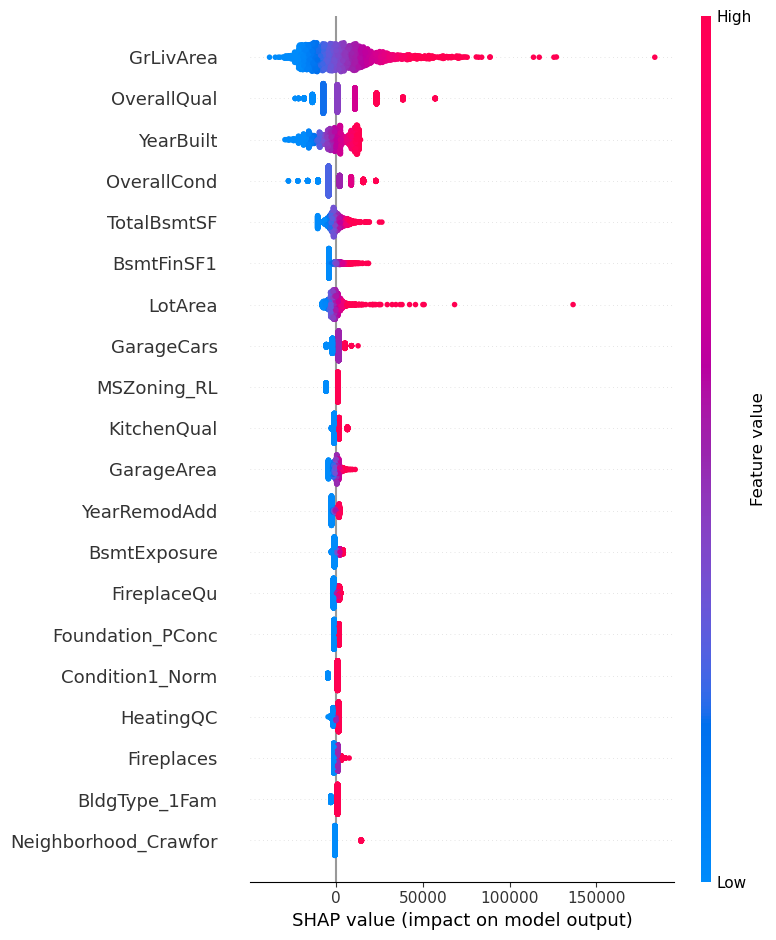

In [9]:
shap.summary_plot(exp_all_lasso)

## Lasso SHAP
### Features combined 

In [10]:
# Create a SHAP explainer for the Lasso model
explainer_lasso_comb = shap.LinearExplainer(lasso_pipe.named_steps['Regressor'].regressor_,
                          masker = lasso_pipe.named_steps['Preprocess'].transform(X))

# Calculate SHAP values for the transformed test set
shap_values_lasso_comb = explainer_lasso_comb(lasso_pipe.named_steps['Preprocess'].transform(X))

# Get feature names after transformation
transformed_feature_names = lasso_pipe.named_steps['Preprocess'].get_feature_names_out()

# Convert SHAP values and transformed data to DataFrame for easier manipulation
# transform Explanation type into a df with named columns 
shap_values_df_lasso_comb = pd.DataFrame(shap_values_lasso_comb.values, columns=transformed_feature_names)

# correct categorical prefixes so encoded variables can be combined"
categorical_prefixes = categorical_columns_selector(X)
categorical_prefixes = ["one-hot-encoder__" + word for word in categorical_prefixes]
categorical_prefixes

for prefix in categorical_prefixes:
    # Get columns that start with the prefix
    columns = [col for col in transformed_feature_names if col.startswith(prefix)]
    
    # Calculate mean SHAP value for these columns
    shap_values_df_lasso_comb[prefix] = shap_values_df_lasso_comb[columns].mean(axis=1)
    
    # Drop the individual encoded columns
    shap_values_df_lasso_comb.drop(columns=columns, inplace=True)

# find the base_value and use it to convert shap values back to dollars
# Use this to find the dollar value home with just that particular feature
# the subtract the bv of the home to see the exact value for that feature 
bv = shap_values_lasso_comb.base_values[0]
dollar_shap_values_lasso_comb = np.exp(bv + shap_values_df_lasso_comb) - np.exp(bv)
    
# Get rid of prefixes
dollar_shap_values_lasso_comb.columns = dollar_shap_values_lasso_comb.columns.str.replace('robust_scaler__', 
                                                                    '', 
                                                                    regex=False)
dollar_shap_values_lasso_comb.columns = dollar_shap_values_lasso_comb.columns.str.replace('one-hot-encoder__', 
                                                                    '', 
                                                                    regex=False)

# reorder X columns so the original values are in the same order as the shap df
X_new_order = list(numerical_columns) + list(categorical_columns)
X_new_order =X[X_new_order]

# Create a shap.Explanation with scaled shap values and correct feature names 
exp_lasso_comb = shap.Explanation(dollar_shap_values_lasso_comb.values, 
                       np.exp(shap_values_lasso_comb.base_values),
                       X_new_order)

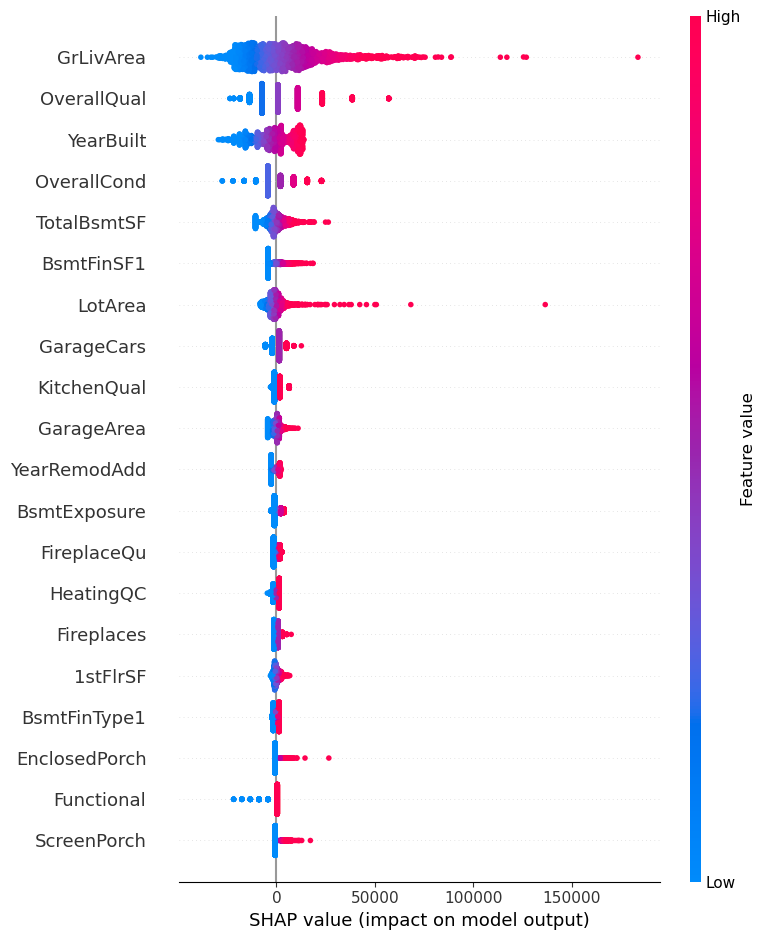

In [11]:
shap.summary_plot(exp_lasso_comb)

# XGB 
## Tuned with Optuna

In [170]:
categorical_preprocessor_OHE = OneHotEncoder(handle_unknown="ignore", drop = None)
categorical_preprocessor_O =  OrdinalEncoder(handle_unknown="use_encoded_value", 
                                           unknown_value= -1)
numerical_preprocessor = StandardScaler()

preprocessor_OHE = ColumnTransformer(
    [
        ("standard_scaler", numerical_preprocessor, numerical_columns),
        ("encoder", categorical_preprocessor_OHE, categorical_columns),
    ]
)

preprocessor_O = ColumnTransformer(
    [
        ("standard_scaler", numerical_preprocessor, numerical_columns),
        ("encoder", categorical_preprocessor_O, categorical_columns),
    ]
)


xgb =  XGBRegressor(max_depth= 4,
                    learning_rate= 0.04643973848790804,
                    subsample= 0.5797329944770706,
                    colsample_bytree= 0.527504939004116,
                    n_estimators= 905,
                    min_child_weight= 3)


xgb_pipe_OHE = Pipeline(steps=[("Preprocess", preprocessor_OHE), 
                               ("Regressor", TransformedTargetRegressor(regressor =xgb,
                                                                          func =np.log, inverse_func=np.exp))])

xgb_pipe_O = Pipeline(steps=[("Preprocess", preprocessor_O), ("XGB", xgb)])


scores_OHE = cross_val_score(xgb_pipe_OHE, X, y, cv = kf, error_score='raise')

scores_O = cross_val_score(xgb_pipe_O, X, y, cv = kf, error_score='raise')


print('XGB OneHot')
print('score', scores_OHE.mean())
print('standard deviation', scores_OHE.std())

xgb_pipe_OHE.fit(X,y)

xgb_OHE_predictions = xgb_pipe_OHE.predict(X)
print('predicted prices', xgb_OHE_predictions)

xgb_OHE_mae = mean_absolute_error(y, xgb_OHE_predictions)
print('Mean Absolute Error:', xgb_OHE_mae)

xgb_OHE_mpv = xgb_OHE_predictions.mean()
print ('Mean Predicted Home Value', xgb_OHE_mpv)

mhv = y.mean()
print ('Mean  Home Value', mhv)

print('         ')
print('XGB Ordinal')
print('score', scores_O.mean())
print('standard deviation', scores_O.std())

xgb_pipe_O.fit(X,y)

xgb_O_predictions = xgb_pipe_O.predict(X)
print('predicted prices', xgb_O_predictions)

xgb_O_mae = mean_absolute_error(y, xgb_O_predictions)
print('Mean Absolute Error:', xgb_O_mae)

xgb_O_mpv = xgb_O_predictions.mean()
print ('Mean Predicted Home Value', xgb_O_mpv)

mhv = y.mean()
print ('Mean  Home Value', mhv)



XGB OneHot
score 0.9538790152827454
standard deviation 0.004298267507064383
predicted prices [123684.31  136620.55  121025.016 ... 144983.69  219554.66  219634.23 ]
Mean Absolute Error: 4284.175757809151
Mean Predicted Home Value 173185.95
Mean  Home Value 173427.01285897984
         
XGB Ordinal
score 0.9514839204613024
standard deviation 0.0037904597932120862
predicted prices [122851.55 136797.58 121850.96 ... 144140.02 222936.81 216420.14]
Mean Absolute Error: 3953.066630612409
Mean Predicted Home Value 173423.78
Mean  Home Value 173427.01285897984


## XGB feature imprtance 
### One hot encoder

In [13]:
xgb_pipe_OHE.fit(X, y)

# Extracting feature importances
# Get the coefficients from the Lasso model
#xgb_regressor = xgb_pipe.named_steps['Regressor'].regressor_
#feature_imp = xgb_regressor.feature_importances_
feature_imp = xgb_pipe_OHE.named_steps['XGB'].feature_importances_
# Get the feature names after preprocessing
transformed_feature_names = xgb_pipe_OHE.named_steps['Preprocess'].get_feature_names_out()

# Combine the feature names and coefficients into a DataFrame
feature_importance_xgb_oh = pd.DataFrame({'Feature': transformed_feature_names, 'Importance': feature_imp})

# Sort the DataFrame by importance
feature_importance_xgb_oh = feature_importance_xgb_oh.sort_values(by='Importance', ascending=False)


feature_importance_xgb_oh['Feature'] = feature_importance_xgb_oh['Feature'].str.replace('standard_scaler__', '', regex=False)
feature_importance_xgb_oh['Feature'] = feature_importance_xgb_oh['Feature'].str.replace('encoder__', '', regex=False)
feature_importance_xgb_oh.head(10)

Feature  Importance
9   OverallQual    0.178614
41   GarageCars    0.107363
14    ExterQual    0.056316
54    Bathrooms    0.046264
60  MSZoning_RM    0.034539
35  KitchenQual    0.027540
0     GrLivArea    0.026545
38   Fireplaces    0.023327
42   GarageArea    0.018785
24  TotalBsmtSF    0.016916

## XGB feature imprtance 
### Ordinal encoder

In [21]:
xgb_pipe_O.fit(X, y)

# Extracting feature importances
# Get the coefficients from the Lasso model
#xgb_regressor = xgb_pipe.named_steps['Regressor'].regressor_
#feature_imp = xgb_regressor.feature_importances_
feature_imp = xgb_pipe_O.named_steps['XGB'].feature_importances_
# Get the feature names after preprocessing
transformed_feature_names = xgb_pipe_O.named_steps['Preprocess'].get_feature_names_out()

# Combine the feature names and coefficients into a DataFrame
feature_importance_xgb_o = pd.DataFrame({'Feature': transformed_feature_names, 'Importance': feature_imp})

# Sort the DataFrame by importance
feature_importance_xgb_o = feature_importance_xgb_o.sort_values(by='Importance', ascending=False)

feature_importance_xgb_o['Feature'] = feature_importance_xgb_o['Feature'].str.replace('standard_scaler__', '', regex=False)
feature_importance_xgb_o['Feature'] = feature_importance_xgb_o['Feature'].str.replace('encoder__', '', regex=False)

feature_importance_xgb_o.head(10)

Feature  Importance
9   OverallQual    0.246695
41   GarageCars    0.121224
54    Bathrooms    0.067107
35  KitchenQual    0.042398
14    ExterQual    0.037956
0     GrLivArea    0.032138
38   Fireplaces    0.030368
72   GarageType    0.023609
24  TotalBsmtSF    0.023527
44   GarageCond    0.022935

## XGB SHAP
### One hot encoder

In [174]:
# This is the same code as Lasso one hot combined but for xgb one hot 
explainer_xgb_oh = shap.Explainer(xgb_pipe_OHE.named_steps['Regressor'].regressor_,
                          masker = xgb_pipe_OHE.named_steps['Preprocess'].transform(X))

# Calculate SHAP values for the transformed test set
shap_values_xgb_oh = explainer_xgb_oh(xgb_pipe_OHE.named_steps['Preprocess'].transform(X))

# Get feature names after transformation
transformed_feature_names = xgb_pipe_OHE.named_steps['Preprocess'].get_feature_names_out()

# Convert SHAP values and transformed data to DataFrame for easier manipulation
# transform Explanation type into a df with named columns 
shap_values_df_xgb_ohe = pd.DataFrame(shap_values_xgb_oh.values, columns=transformed_feature_names)

    
# correct categorical prefixes so encoded variables can be combined"
categorical_prefixes = categorical_columns_selector(X)
categorical_prefixes = ["one-hot-encoder__" + word for word in categorical_prefixes]
categorical_prefixes

for prefix in categorical_prefixes:
    # Get columns that start with the prefix
    columns = [col for col in transformed_feature_names if col.startswith(prefix)]
    
    # Calculate mean SHAP value for these columns
    shap_values_df_xgb_ohe[prefix] = shap_values_df_xgb_ohe[columns].mean(axis=1)
    
    # Drop the individual encoded columns
    shap_values_df_xgb_ohe.drop(columns=columns, inplace=True)

# find the base_value and use it to convert shap values back to dollars
# Use this to find the dollar value home with just that particular feature
# the subtract the bv of the home to see the exact value for that feature 
bv = shap_values_xgb_oh.base_values[0]
shap_values_df_xgb_oh = np.exp(bv + shap_values_df_xgb_ohe) - np.exp(bv)
    
# Get rid of prefixes
shap_values_df_xgb_oh.columns = shap_values_df_xgb_oh.columns.str.replace('standard_scaler__', 
                                                                    '', 
                                                                    regex=False)
shap_values_df_xgb_oh.columns = shap_values_df_xgb_oh.columns.str.replace('one-hot-encoder__', 
                                                                    '', 
                                                                    regex=False)



 99%|===================| 2307/2333 [00:26<00:00]        

In [175]:
# Create a shap.Explanation with scaled shap values and correct feature names 
exp__all_xgb_ohe = shap.Explanation(shap_values_df_xgb_oh.values, 
                       np.exp(shap_values_xgb_oh.base_values),
                       X_new_order)

shap.summary_plot(exp_all_xgb_oh, max_display= 20)

In [15]:
explainer_xgb_oh = shap.Explainer(xgb_pipe_OHE.named_steps['XGB'],
                          masker = xgb_pipe_OHE.named_steps['Preprocess'].transform(X))

# Calculate SHAP values for the transformed test set
shap_values_xgb_oh = explainer_xgb_oh(xgb_pipe_OHE.named_steps['Preprocess'].transform(X))

# Get feature names after transformation
transformed_feature_names = xgb_pipe_OHE.named_steps['Preprocess'].get_feature_names_out()

# Convert SHAP values and transformed data to DataFrame for easier manipulation
# transform Explanation type into a df with named columns 
shap_values_df_xgb_oh = pd.DataFrame(shap_values_xgb_oh.values, columns=transformed_feature_names)

    
# Get rid of prefixes
shap_values_df_xgb_oh.columns = shap_values_df_xgb_oh.columns.str.replace('standard_scaler__', 
                                                                    '', 
                                                                    regex=False)
shap_values_df_xgb_oh.columns = shap_values_df_xgb_oh.columns.str.replace('encoder__', 
                                                                    '', 
                                                                    regex=False)

 95%|=================== | 2223/2333 [00:17<00:00]       

In [16]:
X_xgb = pd.DataFrame(xgb_pipe_OHE.named_steps['Preprocess'].transform(X))
X_xgb.columns = shap_values_df_xgb_oh.columns
X_xgb[numerical_columns] = X[numerical_columns]

exp_all_xgb_oh = shap.Explanation(shap_values_df_xgb_oh.values, 
                           shap_values_xgb_oh.base_values, 
                           X_xgb
                         )

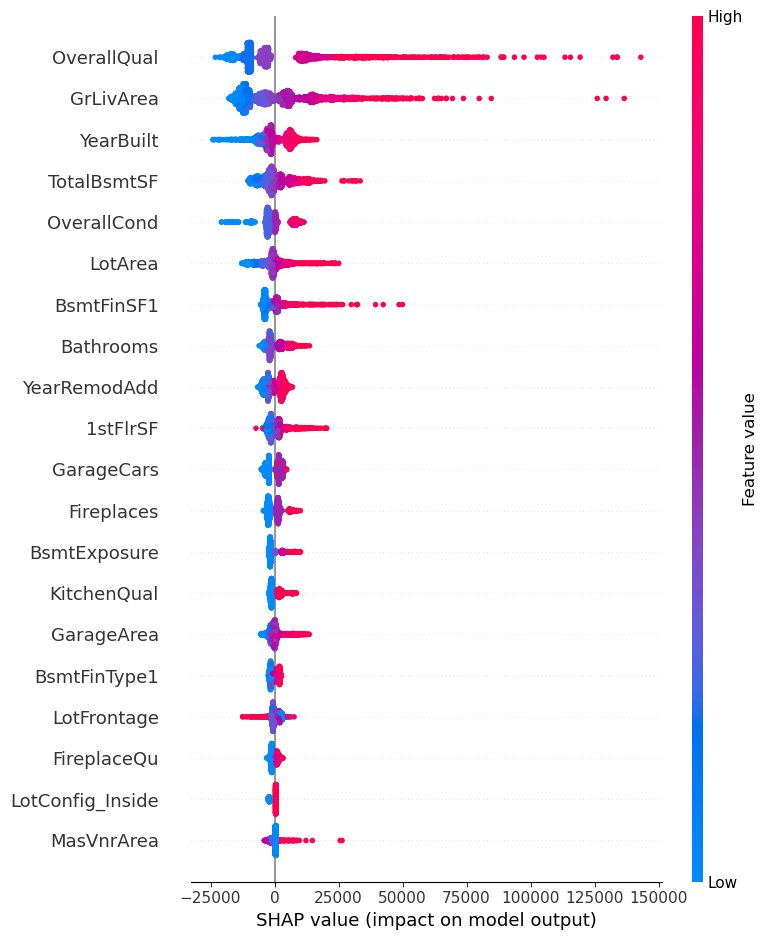

In [17]:
shap.summary_plot(exp_all_xgb_oh, max_display= 20)

## XGB SHAP
### Ordinal encoder

In [18]:
explainer_xgb_o = shap.Explainer(xgb_pipe_O.named_steps['XGB'],
                          masker = xgb_pipe_O.named_steps['Preprocess'].transform(X))

# Calculate SHAP values for the transformed test set
shap_values_xgb_o = explainer_xgb_o(xgb_pipe_O.named_steps['Preprocess'].transform(X))

# Get feature names after transformation
transformed_feature_names = xgb_pipe_O.named_steps['Preprocess'].get_feature_names_out()

# Convert SHAP values and transformed data to DataFrame for easier manipulation
# transform Explanation type into a df with named columns 
shap_values_df_xgb_o = pd.DataFrame(shap_values_xgb_o.values, columns=transformed_feature_names)

shap_values_df_xgb_o.columns = shap_values_df_xgb_o.columns.str.replace('standard_scaler__', 
                                                                    '', 
                                                                    regex=False)
shap_values_df_xgb_o.columns = shap_values_df_xgb_o.columns.str.replace('encoder__', 
                                                                    '', 
                                                                    regex=False)


 94%|=================== | 2198/2333 [00:17<00:01]       

In [22]:
X_xgb_o = pd.DataFrame(xgb_pipe_O.named_steps['Preprocess'].transform(X))
X_xgb_o.columns = shap_values_df_xgb_o.columns
X_xgb_o[numerical_columns] = X[numerical_columns]
X_xgb_o

exp_all_xgb_o = shap.Explanation(shap_values_df_xgb_o.values, 
                           shap_values_xgb_o.base_values, 
                           X_xgb_o
                         )

In [186]:
X_new_order

GrLivArea  MSSubClass  LotFrontage  LotArea  Alley  LotShape  \
0           856          30    62.472926     7890    0.0         1   
1          1049         120    42.000000     4235    0.0         1   
2          1001          30    60.000000     6060    0.0         1   
3          1039          70    80.000000     8146    0.0         1   
4          1665          60    70.000000     8400    0.0         1   
...         ...         ...          ...      ...    ...       ...   
2328        952          30    70.105866     8854    0.0         1   
2329       1733          20   108.318076    13680    0.0         2   
2330       2002          90    82.000000     6270    0.0         1   
2331       1842          60    69.884162     8826    0.0         1   
2332       1911          60    80.000000     9554    0.0         2   

      LandContour  Utilities  LandSlope  OverallQual  ...  Foundation  \
0               4          4          3           36  ...      CBlock   
1               4          4          3           25  ...      CBlock   
2               4          4          3           25  ...      BrkTil   
3               4          4          3           16  ...      BrkTil   
4               4          4          3           64  ...       PConc   
...           ...        ...        ...          ...  ...         ...   
2328            4          4          3           36  ...      BrkTil   
2329            4          4          3            9  ...        Slab   
2330            2          4          3           25  ...      CBlock   
2331            4          4          3           49  ...       PConc   
2332            4          4          3           64  ...       PConc   

      Heating  CentralAir  Electrical  GarageType  GarageYN  PoolYN  Fence  \
0        GasA           Y       SBrkr      Detchd       yes      no     NO   
1        GasA           Y       SBrkr      Attchd       yes      no     NO   
2        GasA           Y       SBrkr      Detchd       yes      no     NO   
3        GasA           Y       SBrkr      Detchd       yes      no     NO   
4        GasA           Y       SBrkr      Attchd       yes      no     NO   
...       ...         ...         ...         ...       ...     ...    ...   
2328     Grav           N       FuseF      Detchd       yes      no     NO   
2329     GasA           Y       FuseA      Attchd       yes      no     NO   
2330     GasA           N       FuseA      2Types       yes      no     NO   
2331     GasA           Y       SBrkr      Attchd       yes      no     NO   
2332     GasA           Y       SBrkr      Attchd       yes      no     NO   

      SaleType  SaleCondition  
0          WD          Normal  
1          WD          Normal  
2          WD          Normal  
3          WD          Normal  
4          WD          Normal  
...        ...            ...  
2328       WD          Normal  
2329       WD          Normal  
2330       WD          Normal  
2331       WD          Normal  
2332       WD          Normal  

[2333 rows x 78 columns]

In [185]:
X_xgb_o

GrLivArea  MSSubClass  LotFrontage  LotArea  Alley  LotShape  \
0           856          30    62.472926     7890    0.0         1   
1          1049         120    42.000000     4235    0.0         1   
2          1001          30    60.000000     6060    0.0         1   
3          1039          70    80.000000     8146    0.0         1   
4          1665          60    70.000000     8400    0.0         1   
...         ...         ...          ...      ...    ...       ...   
2328        952          30    70.105866     8854    0.0         1   
2329       1733          20   108.318076    13680    0.0         2   
2330       2002          90    82.000000     6270    0.0         1   
2331       1842          60    69.884162     8826    0.0         1   
2332       1911          60    80.000000     9554    0.0         2   

      LandContour  Utilities  LandSlope  OverallQual  ...  Foundation  \
0               4          4          3           36  ...         1.0   
1               4          4          3           25  ...         1.0   
2               4          4          3           25  ...         0.0   
3               4          4          3           16  ...         0.0   
4               4          4          3           64  ...         2.0   
...           ...        ...        ...          ...  ...         ...   
2328            4          4          3           36  ...         0.0   
2329            4          4          3            9  ...         3.0   
2330            2          4          3           25  ...         1.0   
2331            4          4          3           49  ...         2.0   
2332            4          4          3           64  ...         2.0   

      Heating  CentralAir  Electrical  GarageType  GarageYN  PoolYN  Fence  \
0         1.0         1.0         3.0         5.0       1.0     0.0    4.0   
1         1.0         1.0         3.0         1.0       1.0     0.0    4.0   
2         1.0         1.0         3.0         5.0       1.0     0.0    4.0   
3         1.0         1.0         3.0         5.0       1.0     0.0    4.0   
4         1.0         1.0         3.0         1.0       1.0     0.0    4.0   
...       ...         ...         ...         ...       ...     ...    ...   
2328      3.0         0.0         1.0         5.0       1.0     0.0    4.0   
2329      1.0         1.0         0.0         1.0       1.0     0.0    4.0   
2330      1.0         0.0         0.0         0.0       1.0     0.0    4.0   
2331      1.0         1.0         3.0         1.0       1.0     0.0    4.0   
2332      1.0         1.0         3.0         1.0       1.0     0.0    4.0   

      SaleType  SaleCondition  
0          8.0            0.0  
1          8.0            0.0  
2          8.0            0.0  
3          8.0            0.0  
4          8.0            0.0  
...        ...            ...  
2328       8.0            0.0  
2329       8.0            0.0  
2330       8.0            0.0  
2331       8.0            0.0  
2332       8.0            0.0  

[2333 rows x 78 columns]

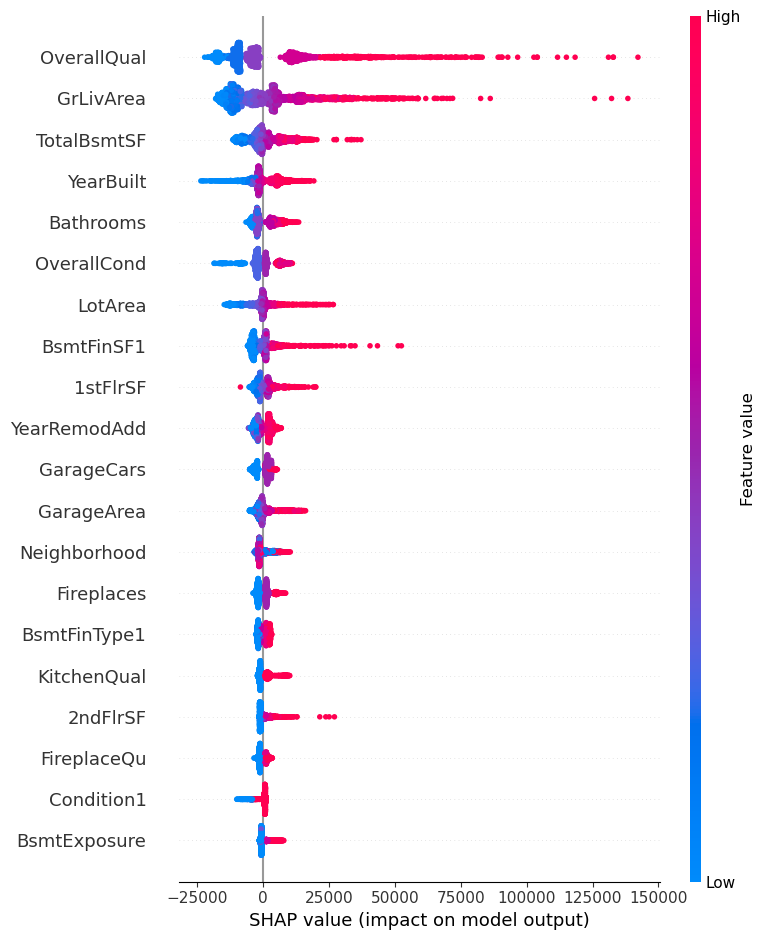

In [23]:
shap.summary_plot(exp_all_xgb_o, max_display= 20)


 # Lasso vs. XGB

In [157]:
import plotly.express as px
import pandas as pd

# Assuming X is a DataFrame and y, predictions are Series
# Combine y and predictions into a DataFrame for easy handling
data = pd.DataFrame({
    'GrLivArea': X['GrLivArea'],
    'OverallQual': X['OverallQual'],
    'Error': y - lasso_predictions
})

# Create the plot
fig = px.scatter(
    data, x='GrLivArea', y='Error',
    color=np.sqrt(X.OverallQual), 
    title=f'Lasso: Living Area vs. Prediction Error<br><sup>Mean Absolute Error: ${lasso_mae:.2f}</sup>',
    labels={'GrLivArea': 'Above Ground Living Area (Square Feet)', 
            'Error': 'Error ($)',
            'color': ''},
    color_continuous_scale='Turbo'
)

# Add a horizontal line at y=0
fig.add_shape(type="line",
              x0=min(data['GrLivArea']), x1=max(data['GrLivArea']),
              y0=0, y1=0,
              line=dict(color="red", dash="dash"))


fig.update_layout(
    yaxis_range=[-100000, 100000],
    yaxis_title_standoff=0  
)

fig.add_annotation(
    x=1.1,  # Adjust the x position as needed
    y=1.1,  # Adjust the y position as needed
    text="Overall<br>Quality",  # Custom legend title with line break
    showarrow=False,
    xref="paper",
    yref="paper",
    align="left",
    font=dict(size=13)
)
# Show plot
fig.show()

fig.write_image("images/lasso_error.png")

In [171]:
# xgb_predictions = xgb_pipe_OHE.predict(X)
# xgb_mae = mean_absolute_error(y, xgb_predictions)
import plotly.express as px
import pandas as pd

# Assuming X is a DataFrame and y, predictions are Series
# Combine y and predictions into a DataFrame for easy handling
data = pd.DataFrame({
    'GrLivArea': X['GrLivArea'],
    'OverallQual': X['OverallQual'],
    'Error': y - xgb_OHE_predictions
})

# Create the plot
fig = px.scatter(
    data, x='GrLivArea', y='Error',
    color=np.sqrt(X.OverallQual), 
    title=f'XGB: Living Area vs. Prediction Error<br><sup>Mean Absolute Error: ${xgb_OHE_mae:.2f}</sup>',
    labels={'GrLivArea': 'Above Ground Living Area (Square Feet)', 
            'Error': 'Error ($)', 
            'color': ''},
    color_continuous_scale='Turbo'
)

# Add a horizontal line at y=0
fig.add_shape(type="line",
              x0=min(data['GrLivArea']), x1=max(data['GrLivArea']),
              y0=0, y1=0,
              line=dict(color="red", dash="dash"))

fig.update_layout(
    yaxis_range=[-100000, 100000],
    yaxis_title_standoff=0
)

fig.add_annotation(
    x=1.1,  # Adjust the x position as needed
    y=1.1,  # Adjust the y position as needed
    text="Overall<br>Quality",  # Custom legend title with line break
    showarrow=False,
    xref="paper",
    yref="paper",
    align="left",
    font=dict(size=13)
)

# Show plot
fig.show()

fig.write_image("images/xgb_error.png")

In [176]:
# fig = px.scatter(
#     x=X.Neighborhood, 
#     y=shap_values_df_xgb_o.Neighborhood, 
#     color = np.sqrt(X.OverallQual),
#     labels={'x': 'Overall Quality', 'y': 'Neighborhood SHAP Values'},
#     title='Overall Quality vs Neighborhood SHAP Values'
# )

# # Show the plot
# fig.show()
import plotly.graph_objs as go

trace1 = go.Scatter(
    x=X.LotArea,
    y=shap_values_df_xgb_oh.LotArea,
    mode='markers',
    name='XGB'
)
trace2 = go.Scatter(
    x=X.LotArea,
    y= dollar_shap_values_lasso_comb.LotArea,
    mode='markers',
    name='Lasso'
)

# Create the layout
layout = go.Layout(
    title='Lot Area SHAP Values',
    xaxis=dict(title='Lot (square feet)'),
    yaxis=dict(title='SHAP Values'),
)

fig = go.Figure(data=[trace1, trace2], layout=layout)

fig.show()

In [165]:
# fig = px.scatter(
#     x=X.Neighborhood, 
#     y=shap_values_df_xgb_o.Neighborhood, 
#     color = np.sqrt(X.OverallQual),
#     labels={'x': 'Overall Quality', 'y': 'Neighborhood SHAP Values'},
#     title='Overall Quality vs Neighborhood SHAP Values'
# )

# # Show the plot
# fig.show()
import plotly.graph_objs as go

trace1 = go.Scatter(
    x=X.MSZoning,
    y=shap_values_df_xgb_o.MSZoning,
    mode='markers',
    name='XGB'
)
trace2 = go.Scatter(
    x=X.MSZoning,
    y= dollar_shap_values_lasso_comb.MSZoning,
    mode='markers',
    name='Lasso'
)

# Create the layout
layout = go.Layout(
    title='Zoning SHAP Values',
    xaxis=dict(title='Zoning'),
    yaxis=dict(title='SHAP Values'),
)

fig = go.Figure(data=[trace1, trace2], layout=layout)

fig.show()

In [137]:
# fig = px.scatter(
#     x=X.Neighborhood, 
#     y=shap_values_df_xgb_o.Neighborhood, 
#     color = np.sqrt(X.OverallQual),
#     labels={'x': 'Overall Quality', 'y': 'Neighborhood SHAP Values'},
#     title='Overall Quality vs Neighborhood SHAP Values'
# )

# # Show the plot
# fig.show()
import plotly.graph_objs as go

trace1 = go.Scatter(
    x=X.TotalBsmtSF,
    y=shap_values_df_xgb_o.TotalBsmtSF,
    mode='markers',
    name='XGB'
)
trace2 = go.Scatter(
    x=X.TotalBsmtSF,
    y= dollar_shap_values_lasso_comb.TotalBsmtSF,
    mode='markers',
    name='Lasso'
)

# Create the layout
layout = go.Layout(
    title='Basement SHAP Values',
    xaxis=dict(title='Basement (square feet)'),
    yaxis=dict(title='SHAP Values'),
)

fig = go.Figure(data=[trace1, trace2], layout=layout)

fig.show()

In [140]:
# fig = px.scatter(
#     x=X.Neighborhood, 
#     y=shap_values_df_xgb_o.Neighborhood, 
#     color = np.sqrt(X.OverallQual),
#     labels={'x': 'Overall Quality', 'y': 'Neighborhood SHAP Values'},
#     title='Overall Quality vs Neighborhood SHAP Values'
# )

# # Show the plot
# fig.show()
import plotly.graph_objs as go

trace1 = go.Scatter(
    x=X.TotalBsmtSF,
    y=shap_values_df_xgb_o.BsmtFinSF1,
    mode='markers',
    name='XGB'
)
trace2 = go.Scatter(
    x= X.TotalBsmtSF,
    y= dollar_shap_values_lasso_comb.BsmtFinSF1,
    mode='markers',
    name='Lasso'
)

# Create the layout
layout = go.Layout(
    title='Basement SHAP Values',
    xaxis=dict(title='Basement (square feet)'),
    yaxis=dict(title='SHAP Values'),
)

fig = go.Figure(data=[trace1], layout=layout)

fig.show()

In [129]:
# fig = px.scatter(
#     x=X.Neighborhood, 
#     y=shap_values_df_xgb_o.Neighborhood, 
#     color = np.sqrt(X.OverallQual),
#     labels={'x': 'Overall Quality', 'y': 'Neighborhood SHAP Values'},
#     title='Overall Quality vs Neighborhood SHAP Values'
# )

# # Show the plot
# fig.show()
import plotly.graph_objs as go

trace1 = go.Scatter(
    x=X.GarageCars,
    y=shap_values_df_xgb_o.GarageCars,
    mode='markers',
    name='XGB'
)
trace2 = go.Scatter(
    x= X.GarageCars,
    y= dollar_shap_values_lasso_comb.GarageCars,
    mode='markers',
    name='Lasso'
)

# Create the layout
layout = go.Layout(
    title='Garage Cars SHAP Values',
    xaxis=dict(title='Cars'),
    yaxis=dict(title='SHAP Values'),
)

fig = go.Figure(data=[trace1, trace2], layout=layout)

fig.show()

In [172]:
# fig = px.scatter(
#     x=X.Neighborhood, 
#     y=shap_values_df_xgb_o.Neighborhood, 
#     color = np.sqrt(X.OverallQual),
#     labels={'x': 'Overall Quality', 'y': 'Neighborhood SHAP Values'},
#     title='Overall Quality vs Neighborhood SHAP Values'
# )

# # Show the plot
# fig.show()
import plotly.graph_objs as go

trace1 = go.Scatter(
    x=X.Neighborhood,
    y=shap_values_df_xgb_o.Neighborhood,
    mode='markers',
    name='XGB'
)
trace2 = go.Scatter(
    x= X.Neighborhood,
    y= dollar_shap_values_lasso_comb.Neighborhood,
    mode='markers',
    name='Lasso'
)

# Create the layout
layout = go.Layout(
    title='Neighborhood SHAP Values',
    xaxis=dict(title='Neighborhood'),
    yaxis=dict(title='SHAP Values ($)'),
)

fig = go.Figure(data=[trace1, trace2], layout=layout)

fig.show()

fig.write_image("images/neighborhood_SHAP.png")

In [36]:
import plotly.graph_objs as go

trace1 = go.Scatter(
    x= X.GrLivArea,
    y=shap_values_df_xgb_o.GrLivArea,
    mode='markers',
    name='XGB'
)
trace2 = go.Scatter(
    x= X.GrLivArea,
    y= dollar_shap_values_lasso_comb.GrLivArea,
    mode='markers',
    name='Lasso'
)

# Create the layout
layout = go.Layout(
    title='Living Area SHAP Values',
    xaxis=dict(title='Above Ground Living Area (Square Feet)'),
    yaxis=dict(title='SHAP Values'),
)

fig = go.Figure(data=[trace1, trace2], layout=layout)

fig.show()

In [118]:
import plotly.graph_objs as go

trace1 = go.Scatter(
    x= X.ScreenPorch,
    y=shap_values_df_xgb_o.ScreenPorch,
    mode='markers',
    name='XGB'
)
trace2 = go.Scatter(
    x= X.ScreenPorch,
    y= dollar_shap_values_lasso_comb.ScreenPorch,
    mode='markers',
    name='Lasso'
)

# Create the layout
layout = go.Layout(
    title='Screen Porch SHAP Values',
    xaxis=dict(title='Screen Porch Area(Square Feet)'),
    yaxis=dict(title='SHAP Values'),
)

fig = go.Figure(data=[trace1, trace2], layout=layout)

fig.show()

In [159]:
fig = px.scatter(
    x=shap_values_df_xgb_o.GrLivArea,
    y=shap_values_df_xgb_o.OverallQual,
    color=np.sqrt(X.OverallQual), 
    title='Living Area SHAP vs. Overall Quality SHAP',
    color_continuous_scale='Turbo'
)

fig.show()

In [162]:
color = X.Neighborhood

color_transformed = []
for word in color:
    if word == 'Crawfor':
        color_transformed.append('Crawfor')
    elif word == 'StoneBr':
        color_transformed.append('StoneBr')
    elif word == 'BrkSide':
        color_transformed.append('BrkSide')
    else:
        color_transformed.append('other')
        
fig = px.scatter(
    x=shap_values_df_xgb_o.YearBuilt,
    y=shap_values_df_xgb_o.Neighborhood,
    color=color_transformed, 
    title='Neighborhood vs. Quality SHAP'
)

fig.show()

In [164]:
fig = px.scatter(
    x=shap_values_df_xgb_o.Neighborhood,
    y=shap_values_df_xgb_o.OverallQual,
    color=color_transformed, 
    title='Neighborhood vs. Quality SHAP'
)

fig.show()

In [67]:
import plotly.graph_objs as go

trace1 = go.Scatter(
    x=shap_values_df_xgb_o.GrLivArea,
    y=shap_values_df_xgb_o.OverallQual,
    mode='markers',
    name='XGB'
)

# Create the layout
layout = go.Layout(
    title='Overall Quality SHAP Values',
    xaxis=dict(title='Sh'),
    yaxis=dict(title='SHAP Values'),
)

fig = go.Figure(data=[trace1], layout=layout)

fig.show()

In [161]:
fig = px.scatter(
    x=dollar_shap_values_lasso_comb.GrLivArea,
    y=dollar_shap_values_lasso_comb.OverallQual,
    color=np.sqrt(X.OverallQual), 
    title='hi',
    color_continuous_scale='Turbo'
)

fig.show()

In [79]:
import plotly.graph_objs as go

trace1 = go.Scatter(
    x=X.KitchenQual,
    y=shap_values_df_xgb_o.KitchenQual,
    mode='markers',
    name='XGB'
)
trace2 = go.Scatter(
    x= X.KitchenQual,
    y= dollar_shap_values_lasso_comb.KitchenQual,
    mode='markers',
    name='Lasso'
)

# Create the layout
layout = go.Layout(
    title='Kitchen Quality SHAP Values',
    xaxis=dict(title='Overall Quality'),
    yaxis=dict(title='SHAP Values'),
)

fig = go.Figure(data=[trace1, trace2], layout=layout)

fig.show()

In [37]:
import plotly.graph_objs as go

trace1 = go.Scatter(
    x=np.sqrt(X.OverallQual),
    y=shap_values_df_xgb_o.OverallQual,
    mode='markers',
    name='XGB'
)
trace2 = go.Scatter(
    x= np.sqrt(X.OverallQual),
    y= dollar_shap_values_lasso_comb.OverallQual,
    mode='markers',
    name='Lasso'
)

# Create the layout
layout = go.Layout(
    title='Overall Quality SHAP Values',
    xaxis=dict(title='Overall Quality'),
    yaxis=dict(title='SHAP Values'),
)

fig = go.Figure(data=[trace1, trace2], layout=layout)

fig.show()

In [38]:
trace1 = go.Scatter(
    x=X.YearBuilt,
    y=shap_values_df_xgb_o.YearBuilt,
    mode='markers',
    name='XGB'
)
trace2 = go.Scatter(
    x= X.YearBuilt,
    y= dollar_shap_values_lasso_comb.YearBuilt,
    mode='markers',
    name='Lasso'
)

# Create the layout
layout = go.Layout(
    title='Year Built SHAP Values',
    xaxis=dict(title='Year Built'),
    yaxis=dict(title='SHAP Value'),
)

fig = go.Figure(data=[trace1, trace2], layout=layout)

fig.show()

# Put predictions into dataframe 

In [39]:
df_predictions = df_normal_quality.copy()
df_predictions['Lasso'] = lasso_predictions
df_predictions['error_Lasso'] = df_predictions.SalePrice - df_predictions.Lasso
df_predictions['xgb'] = xgb_OHE_predictions
df_predictions['error_xgb'] = df_predictions.SalePrice - df_predictions.xgb
df_predictions[['SalePrice', 'Lasso',  'error_Lasso', 'xgb','error_xgb']]

SalePrice          Lasso   error_Lasso            xgb     error_xgb
0        126000  125417.299148    582.700852  121696.250000   4303.750000
1        139500  130118.749495   9381.250505  134283.421875   5216.578125
2        124900  115891.547339   9008.452661  121595.359375   3304.640625
3        114000  105123.287031   8876.712969  105797.468750   8202.531250
4        227000  223707.350576   3292.649424  209003.250000  17996.750000
...         ...            ...           ...            ...           ...
2328     121000  107056.493708  13943.506292  113421.500000   7578.500000
2329     139600  122895.059269  16704.940731  141674.984375  -2074.984375
2330     145000  153058.383032  -8058.383032  148440.640625  -3440.640625
2331     217500  224554.741059  -7054.741059  225128.843750  -7628.843750
2332     215000  223794.237273  -8794.237273  213375.390625   1624.609375

[2333 rows x 5 columns]

In [40]:
trace1 = go.Scatter(
    x=df_predictions.loc[df_predictions.Neighborhood == 'NoRidge'].GrLivArea,
    y=df_predictions.loc[df_predictions.Neighborhood == 'NoRidge'].error_xgb,
    mode='markers',
    name='xgb'
)
trace2 = go.Scatter(
    x=df_predictions.loc[df_predictions.Neighborhood == 'NoRidge'].GrLivArea,
    y=df_predictions.loc[df_predictions.Neighborhood == 'NoRidge'].error_Lasso,
    mode='markers',
    name='Lasso'
)

# Create the layout
layout = go.Layout(
    title='Sale Price vs. Predictions',
    xaxis=dict(title='Sale Price'),
    yaxis=dict(title='Predicted Price'),
)

fig = go.Figure(data=[trace1, trace2], layout=layout)

fig.show()

In [142]:
df_predictions.loc[df_predictions.LotArea > 100000]

PID  GrLivArea  SalePrice  MSSubClass MSZoning  LotFrontage  \
1064  905301050       1824     302000          20       RL   911.748404   

      LotArea Street  Alley  LotShape  ...  Fence  MoSold YrSold  SaleType  \
1064   115149   Pave    0.0         3  ...     NO       6   2007       WD    

     SaleCondition Bathrooms          Lasso   error_Lasso         xgb  \
1064        Normal       3.0  344559.355398 -42559.355398  294522.625   

      error_xgb  
1064   7477.375  

[1 rows x 84 columns]

In [112]:
df_predictions.loc[df_predictions.OverallQual == 100]

PID  GrLivArea  SalePrice  MSSubClass MSZoning  LotFrontage  \
25    528106110       2046     450000          20       RL   105.000000   
51    528164060       2470     615000          20       RL   106.000000   
518   528477050       2007     310000          60       FV    85.000000   
753   528166060       2392     386250          20       RL   103.000000   
807   528351010       4316     755000          60       RL   104.000000   
908   528106020       2402     555000          20       RL   105.000000   
1116  528320060       3627     625000          60       RL   118.000000   
1418  528110020       2674     610000          20       RL   105.000000   
1506  528327060       2633     466500          20       RL    90.265064   
1777  902400110       3608     475000          75       RM    90.000000   
1897  528118090       2790     460000          60       RL    96.000000   
1904  533236090       2393     345000         160       FV    36.000000   
1935  902401120       2775     325000          75       RM    75.000000   
2251  528110010       2296     451950          60       RL    97.000000   
2268  528102040       1718     337500          20       RL    96.000000   

      LotArea Street  Alley  LotShape  ...  Fence  MoSold YrSold  SaleType  \
25      15431   Pave    0.0         1  ...     NO       8   2007       WD    
51      12720   Pave    0.0         1  ...     NO       2   2008       WD    
518     11003   Pave    0.0         1  ...     NO       4   2009       WD    
753     13472   Pave    0.0         1  ...     NO       6   2009       WD    
807     21535   Pave    0.0         2  ...     NO       1   2007       WD    
908     15431   Pave    0.0         1  ...     NO       4   2009       WD    
1116    35760   Pave    0.0         2  ...     NO       7   2006       WD    
1418    13693   Pave    0.0         1  ...     NO       3   2009       WD    
1506    11400   Pave    0.0         1  ...     NO       3   2007       WD    
1777    22950   Pave    0.0         3  ...  GdPrv       6   2006       WD    
1897    12539   Pave    0.0         1  ...     NO       6   2008       WD    
1904     3951   Pave    2.0         2  ...     NO       2   2008       WD    
1935    13500   Pave    0.0         1  ...     NO       7   2008       WD    
2251    13478   Pave    0.0         2  ...     NO       6   2009     ConLI   
2268    12456   Pave    0.0         1  ...     NO       7   2009       WD    

     SaleCondition Bathrooms          Lasso   error_Lasso           xgb  \
25          Normal       3.5  448008.847871   1991.152129  465092.09375   
51          Normal       3.5  550666.648276  64333.351724  610624.68750   
518         Normal       3.5  364019.901809 -54019.901809  327029.78125   
753         Normal       2.0  437953.801707 -51703.801707  392249.68750   
807         Normal       4.0  839574.083156 -84574.083156  739233.93750   
908         Normal       3.0  551835.508552   3164.491448  546918.31250   
1116        Normal       4.5  656745.473393 -31745.473393  639464.56250   
1418        Normal       4.5  559927.126150  50072.873850  601276.50000   
1506        Normal       3.5  506747.012223 -40247.012223  470566.00000   
1777        Normal       2.5  420286.769298  54713.230702  465701.43750   
1897        Normal       3.5  508262.871120 -48262.871120  461477.21875   
1904        Normal       3.5  379581.373699 -34581.373699  347905.68750   
1935        Normal       3.5  311992.495199  13007.504801  328717.59375   
2251        Normal       3.5  443098.028313   8851.971687  452520.53125   
2268        Normal       3.0  356373.856843 -18873.856843  338660.93750   

        error_xgb  
25   -15092.09375  
51     4375.31250  
518  -17029.78125  
753   -5999.68750  
807   15766.06250  
908    8081.68750  
1116 -14464.56250  
1418   8723.50000  
1506  -4066.00000  
1777   9298.56250  
1897  -1477.21875  
1904  -2905.68750  
1935  -3717.59375  
2251   -570.53125  
2268  -1160.93750  

[15 rows x 84 columns]

In [117]:
df_predictions.ScreenPorch.value_counts()

ScreenPorch
0      2138
144      12
192       8
120       7
168       6
       ... 
154       1
152       1
163       1
208       1
40        1
Name: count, Length: 103, dtype: int64

In [184]:
shap.waterfall_plot(exp_all_lasso[25], max_display= 50)

In [143]:
shap.waterfall_plot(exp_all_xgb_o[1064], max_display= 50)

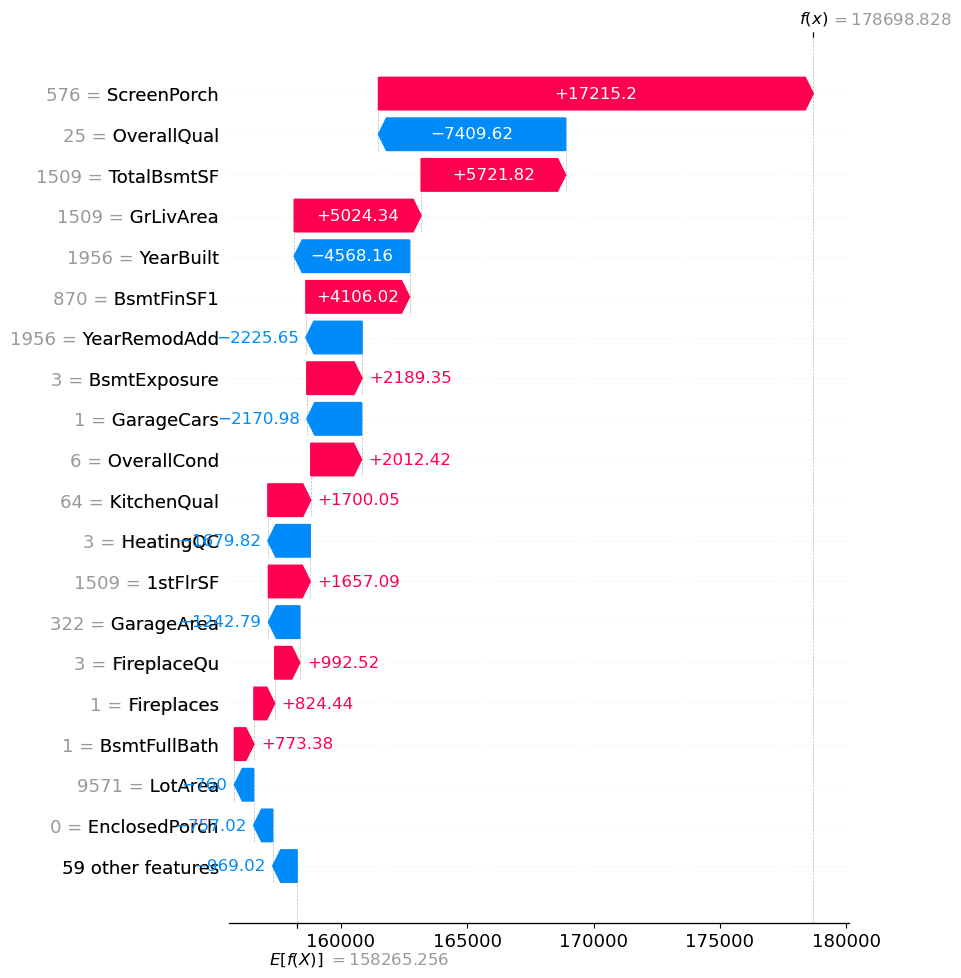

In [125]:
shap.waterfall_plot(exp_lasso_comb[2292], max_display= 20)

In [48]:
trace1 = go.Scatter(
    x=df_predictions.loc[df_predictions.OverallQual == 81].GrLivArea,
    y=df_predictions.loc[df_predictions.OverallQual == 81].error_xgb,
    mode='markers',
    name='xgb'
)
trace2 = go.Scatter(
    x=df_predictions.loc[df_predictions.OverallQual == 81].GrLivArea,
    y=df_predictions.loc[df_predictions.OverallQual == 81].error_Lasso,
    mode='markers',
    name='Lasso'
)

# trace1 = go.Scatter(
#     x=df_predictions.loc[df_predictions.OverallQual ==25 ].GrLivArea,
#     y=df_predictions.loc[df_predictions.OverallQual == 25].error_xgb,
#     mode='markers',
#     name='xgb'
# )
# trace2 = go.Scatter(
#     x=df_predictions.loc[df_predictions.OverallQual == 25].GrLivArea,
#     y=df_predictions.loc[df_predictions.OverallQual == 25].error_Lasso,
#     mode='markers',
#     name='Lasso'
# )

# Create the layout
layout = go.Layout(
    title='Living Area vs. Prediction Error',
    xaxis=dict(title='Living Area (square feet)'),
    yaxis=dict(title='Prediction Error (sale price - prediction)'),
)

fig = go.Figure(data=[trace1, trace2], layout=layout)

fig.show()